In [96]:
# Required packages
import pandas as pd
import numpy as np 
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller as adf
from statsmodels.graphics.gofplots import qqplot
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot
from pandas_datareader import data
from scipy import stats

In [97]:
%matplotlib inline
register_matplotlib_converters()
warnings.filterwarnings('ignore')

### MIHIR MESSING AROUND WITH CURR DATA

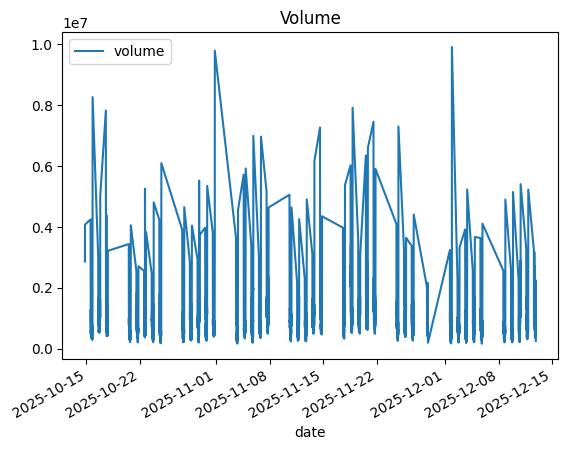

In [ ]:
### THIS WAS ME MESSING AROUND WITH CLEANING, USE TO PRACTICE PLOTTING VOLUME ###


# start_date = dt.datetime.today() - dt.timedelta(days=59)
# curr_data = yf.download("SPY", period="1y", interval="5m", start=start_date)

# SPY_curr = curr_data.rename(columns={"Close": "close", "Volume": "volume", "Open": "open", "High": "high", "Low": "low"})
# SPY_curr.columns = SPY_curr.columns.droplevel("Ticker")
# # # clean data into required format
# SPY_curr_vol = SPY_curr[["volume"]]
# SPY_curr_vol.index.name = "date"
# SPY_curr_vol.columns.name = None
# SPY_curr_vol.index = pd.to_datetime(SPY_curr_vol.index )
# SPY_curr_vol.index = SPY_curr_vol.index.tz_localize(None)
# # SPY_curr_vol

# SPY_curr_vol.plot(title="Volume");plt.show()

In [100]:
ticker = "SPY"

We import our intraday 1 minute data of SPY that ranges from ***2007-04-24*** to ***2020-01-31***.

In [101]:
# Import & clean intraday data
df = pd.read_csv("SPY1min_clean.csv", parse_dates=True)
df['date'] = pd.to_datetime(df['date'])
df['other_date'] = df[['date']]
df = df.set_index('date')
df


,open,high,low,close,volume,barCount,average,other_date
date,,,,,,,,
2008-01-22 07:30:00,126.45,126.82,126.00,126.67,30987,4541,126.283,2008-01-22 07:30:00
2008-01-22 07:31:00,126.67,127.17,126.39,127.12,20111,3125,126.958,2008-01-22 07:31:00
2008-01-22 07:32:00,127.10,127.13,126.71,126.78,11979,2074,126.922,2008-01-22 07:32:00
2008-01-22 07:33:00,126.76,126.90,126.53,126.54,8017,1350,126.675,2008-01-22 07:33:00
2008-01-22 07:34:00,126.54,127.18,126.54,126.78,11967,1253,126.730,2008-01-22 07:34:00
...,...,...,...,...,...,...,...,...
2021-05-06 13:55:00,418.56,418.77,418.48,418.49,9073,4584,418.660,2021-05-06 13:55:00
2021-05-06 13:56:00,418.50,418.73,418.47,418.64,6680,3095,418.622,2021-05-06 13:56:00
2021-05-06 13:57:00,418.64,418.79,418.63,418.79,6912,2868,418.744,2021-05-06 13:57:00


We resample the 1 minute data to a 5 minute timeframe as [Andersen et al (2000)](https://ssrn.com/abstract=267791) argue this sampling interval is optimal for a liquid market.

In [86]:
# Resample 1min to 5min
sample = '5T'
alt_df = df.resample(sample).agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume': 'sum'})
alt_df.dropna(inplace = True)

alt_df.tail()

,open,high,low,close,volume
date,,,,,
2021-05-06 13:35:00,417.15,417.70,417.09,417.68,9305
2021-05-06 13:40:00,417.68,417.98,417.66,417.79,12423
2021-05-06 13:45:00,417.78,418.07,417.65,418.05,14996
2021-05-06 13:50:00,418.04,418.84,418.03,418.56,43476
2021-05-06 13:55:00,418.56,419.21,418.47,419.08,48899


In [87]:
df['other_date'] = pd.to_datetime(df['other_date']).dt.strftime('%Y-%m-%d')

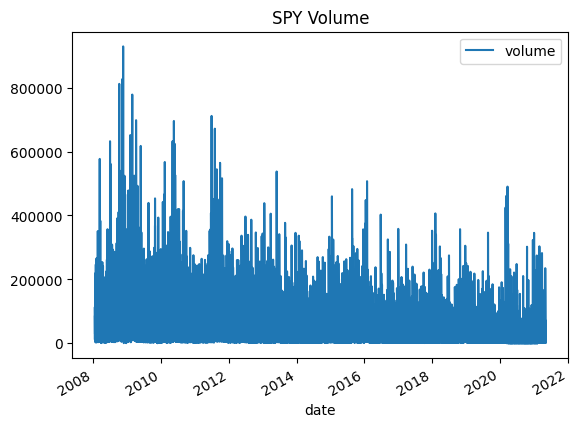

In [88]:
# Download VIX & SPY volume data from yahoo finance
SPY_daily = alt_df[["volume"]]
SPY_daily 
SPY_daily.plot(title = "SPY Volume");plt.show()

Now that we have the data, there are 4 major steps to follow:
- Compute daily realized volatilty from intraday data.
- Average the values over 5 periods to get rolling weekly realized volatility and 22 periods for monthly realized volatility.
- Estimate the HAR-RV coefficients.
- Measure the performance of the model.

We start by computing the daily RV, based on $n$ intraday prices:
$RV^d_t =  \sqrt {\sum_{j=0}^{n-1} r^2_{t-j\Delta}}$

Where:
- $r_{t-j\Delta} = \Delta \left(p_{t-j} - p_{t-(j+1)}\right)$
- $\Delta = 1d/n_{periods}$
- $p_t$ is the price at time $t$
- $n$ is the number of 5 minute bars in a trading day

In [91]:
alt_df

,open,high,low,close,volume
date,,,,,
2008-01-22 07:30:00,126.45,127.18,126.00,126.78,83061
2008-01-22 07:35:00,126.80,127.89,126.12,127.65,69696
2008-01-22 07:40:00,127.58,128.26,127.00,128.10,78193
2008-01-22 07:45:00,128.08,129.30,128.03,129.03,90224
2008-01-22 07:50:00,129.02,129.86,128.92,129.25,113235
...,...,...,...,...,...
2021-05-06 13:35:00,417.15,417.70,417.09,417.68,9305
2021-05-06 13:40:00,417.68,417.98,417.66,417.79,12423
2021-05-06 13:45:00,417.78,418.07,417.65,418.05,14996


In [102]:

### WORKING CODE THAT PULLS FROM YF AND PROCESSES IN THE WAY WE WANT ###

# pull initial data from yfinance
start_date = dt.datetime.today() - dt.timedelta(days=59)
curr_data = yf.download("SPY", period="1y", interval="5m", start=start_date)
curr_data = curr_data[curr_data['Volume'] != 0]
curr_data = curr_data.dropna()

# clean 5m interval data to process best for har-rv
curr_data_cleaned = curr_data.rename(columns={"Close": "close", "Volume": "volume", "Open": "open", "High": "high", "Low": "low"})
curr_data_cleaned.columns = curr_data_cleaned.columns.droplevel("Ticker")
curr_data_cleaned.index = curr_data_cleaned.index.tz_localize(None)
curr_data_cleaned.index.name = "date"
curr_data_cleaned.columns.name = None

curr_data_cleaned

[*********************100%***********************]  1 of 1 completed


,close,high,low,open,volume
date,,,,,
2025-10-14 19:40:00,660.849976,663.130005,660.469971,663.030029,2892654.0
2025-10-14 19:45:00,661.500000,661.789978,660.280029,660.869995,3926029.0
2025-10-14 19:50:00,662.020020,662.330017,661.010010,661.500000,2856129.0
2025-10-14 19:55:00,662.200012,662.609985,661.640015,662.010010,4074102.0
2025-10-15 13:30:00,666.549988,667.164978,666.229980,666.820007,4244583.0
...,...,...,...,...,...
2025-12-12 20:15:00,681.799988,682.065613,681.690002,681.820007,953577.0
2025-12-12 20:20:00,681.945007,681.994995,681.760010,681.804993,700534.0
2025-12-12 20:25:00,681.359985,681.979980,681.109985,681.950012,1457608.0


In [103]:
# Compute number of periods/day
alt_df = curr_data_cleaned
alt_df["D"] = alt_df.index.date
n_periods = alt_df.pivot_table(index = ["D"], aggfunc = 'size').values

stats.describe(n_periods)

DescribeResult(nobs=np.int64(43), minmax=(np.int64(4), np.int64(78)), mean=np.float64(75.30232558139535), variance=np.float64(157.69213732004428), skewness=np.float64(-4.935901303943397), kurtosis=np.float64(23.86214715591099))

We then compute $r^2_{t-j\Delta}$ for all days.  

In [65]:
alt_df.loc[alt_df["D"] != alt_df["D"].shift(), "Per"]  = n_periods
alt_df.fillna(method = 'ffill', inplace = True)

alt_df["Ret"] = np.where(alt_df["D"] == alt_df["D"].shift(),
                    ( (alt_df["close"]-alt_df["close"].shift()) * 1/alt_df["Per"] ) **2, np.nan)

In [66]:
# Perform the sum grouped by days.
rv = alt_df.groupby("D")["Ret"].agg(np.sum).to_frame()

In [67]:
# Add sqrt to get Realized-Vol
rv.columns = ["RV_daily"]
rv["RV_daily"] = np.sqrt(rv["RV_daily"])

In [68]:
date = str(rv["RV_daily"].idxmax())
df["close"].loc[date]

date
2020-03-12 07:30:00    256.32
2020-03-12 07:31:00    256.40
2020-03-12 07:32:00    256.08
2020-03-12 07:33:00    255.66
2020-03-12 07:34:00    255.29
                        ...  
2020-03-12 13:55:00    251.41
2020-03-12 13:56:00    250.11
2020-03-12 13:57:00    250.18
2020-03-12 13:58:00    249.01
2020-03-12 13:59:00    248.08
Name: close, Length: 390, dtype: float64

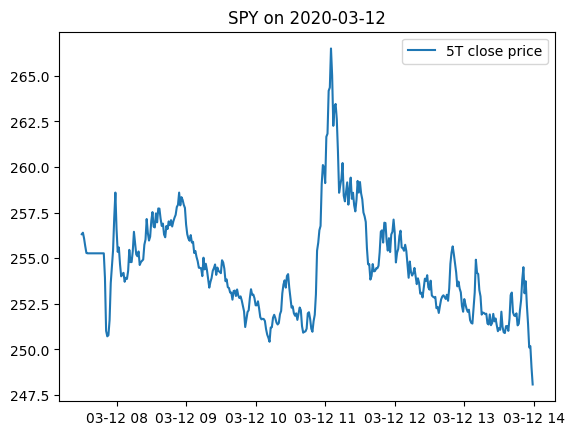

In [69]:
# Check what day in the dataset had the highest realized vol
date = str(rv["RV_daily"].idxmax())
plt.plot(df["close"].loc[date], label = f"{sample} close price")
plt.title(f"{ticker} on {date}")
plt.legend()
plt.show()

We can compute the weekly and monthly RV with:
- Weekly : $RV^w_t = \frac{1}{5} \left(RV^d_{t-1d} + RV^d_{t-2d} + \dots + RV^d_{t-1w}\right)$
- Monthly : $RV^m_t = \frac{1}{21} \left(RV^d_{t-1d} + RV^d_{t-2d} + \dots + RV^d_{t-1m}\right)$

In [70]:
# Compute weekly and monthly RV.  
rv["RV_weekly"] = rv["RV_daily"].rolling(5).mean()
rv["RV_monthly"] = rv["RV_daily"].rolling(21).mean()
rv.dropna(inplace = True)

In [71]:
SPY_daily = SPY_daily.resample('D')['volume'].sum().reset_index()


In [72]:
SPY_daily = SPY_daily.set_index('date')
SPY_daily


,volume
date,
2008-01-22,3507370
2008-01-23,4125554
2008-01-24,2278237
2008-01-25,6967326
2008-01-26,0
...,...
2021-05-02,0
2021-05-03,427874
2021-05-04,737670


In [73]:
rv

,RV_daily,RV_weekly,RV_monthly
D,,,
2008-02-20,0.019807,0.016730,0.022946
2008-02-21,0.017553,0.017335,0.021747
2008-02-22,0.020951,0.017747,0.020663
2008-02-25,0.024622,0.019771,0.020428
2008-02-26,0.016816,0.019950,0.019980
...,...,...,...
2021-04-30,0.027480,0.023479,0.022704
2021-05-03,0.020792,0.023842,0.022887
2021-05-04,0.041962,0.028198,0.023914


In [74]:
#Add IV & Volume variables
rv["SPY_volume"] = SPY_daily.loc[rv.index]
print(rv.head()); print(rv.describe())

            RV_daily  RV_weekly  RV_monthly  SPY_volume
D                                                      
2008-02-20  0.019807   0.016730    0.022946     2009789
2008-02-21  0.017553   0.017335    0.021747     1799178
2008-02-22  0.020951   0.017747    0.020663     5693319
2008-02-25  0.024622   0.019771    0.020428     1737135
2008-02-26  0.016816   0.019950    0.019980     1799681
          RV_daily    RV_weekly   RV_monthly    SPY_volume
count  3327.000000  3327.000000  3327.000000  3.327000e+03
mean      0.016349     0.016339     0.016325  1.665222e+06
std       0.013179     0.011997     0.010441  1.779249e+06
min       0.003274     0.003959     0.006113  1.853590e+05
25%       0.009652     0.010176     0.010545  6.176920e+05
50%       0.013075     0.013277     0.013349  1.104582e+06
75%       0.018375     0.018172     0.019065  1.968072e+06
max       0.202157     0.166490     0.118118  2.315890e+07


In [75]:
# Check for stationarity with adf test
print("p-value for daily RV:", adf(rv["RV_daily"].values)[1])
print("p-value for weekly RV:",adf(rv["RV_weekly"].values)[1])
print("p-value for monthly RV:",adf(rv["RV_monthly"].values)[1])
print("p-value for SPY Volume:",adf(rv["SPY_volume"].values)[1])

p-value for daily RV: 1.2183012629845546e-09
p-value for weekly RV: 7.315002162395725e-08
p-value for monthly RV: 1.1284670837415956e-08
p-value for SPY Volume: 0.0074497542241594205


For all timeframes, the p-value is $\le 0.01$ thus, we reject the null hypothesis that the time series has a unit root.  The time series is stationary.

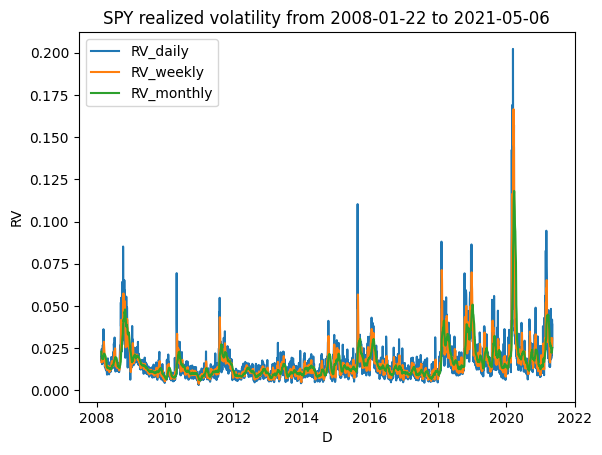

In [76]:
# Plot the RV variables.  
rv[["RV_daily","RV_weekly","RV_monthly"]].plot(title = f"{ticker} realized volatility from {df.index.date[0]} to {df.index.date[-1]}")
plt.ylabel("RV")
plt.show()

As the volume, RVs and VIX price have significantly different ranges, we perform min-max normalization:

$X_{scaled} = \frac{X - min(X)}{max(X)-min(X)}$

In [77]:
# Prepare data 
rv["Target"] = rv["RV_daily"].shift(-1) #We want to predict the RV of the next day.  
rv.dropna(inplace = True)

#Scale the data
rv_scaled = (rv-rv.min())/(rv.max()-rv.min())

#Add constant c
rv_scaled = sm.add_constant(rv_scaled)

#Split train and test sets
split = int(0.60 * rv.shape[0])
X = rv_scaled.drop("Target", axis = 1)
y = rv_scaled[["Target"]]
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [78]:
X_test

,const,RV_daily,RV_weekly,RV_monthly,SPY_volume
D,,,,,
2016-01-22,1.0,0.078582,0.183832,0.164054,0.164826
2016-01-25,1.0,0.084070,0.168427,0.165663,0.035112
2016-01-26,1.0,0.101026,0.156959,0.171215,0.042117
2016-01-27,1.0,0.150598,0.144817,0.178806,0.060314
2016-01-28,1.0,0.149050,0.133648,0.187082,0.043700
...,...,...,...,...,...
2021-04-29,1.0,0.122749,0.112499,0.144188,0.017098
2021-04-30,1.0,0.121714,0.120100,0.148130,0.068678
2021-05-03,1.0,0.088082,0.122331,0.149767,0.010556


In [305]:
cool_df = pd.read_csv("test_data.csv")
cool_df["Date"] = pd.to_datetime(cool_df["Date"])
cool_df['Date'] = pd.to_datetime(cool_df['Date']).dt.strftime('%Y-%m-%d')
cool_df = cool_df.set_index("Date")
cool_df

,Open,High,Low,Close,Volume
Date,,,,,
2025-01-13,575.770020,581.750000,575.349976,581.390015,47910100
2025-01-14,584.359985,585.000000,578.349976,582.190002,48420600
2025-01-15,590.330017,593.940002,589.200012,592.780029,56900200
2025-01-16,594.169983,594.349976,590.929993,591.640015,43319700
2025-01-17,596.960022,599.359985,595.609985,597.580017,58070600
...,...,...,...,...,...
2025-12-04,685.299988,685.369995,681.340027,684.390015,61970300
2025-12-05,685.469971,688.390015,684.580017,685.690002,79241000
2025-12-08,686.590027,686.640015,681.570007,683.630005,55231500


We can now train the parameters for HAR. $\hat{RV_{t+1d}^{d}} = \hat{\beta_0} + \hat{\beta_1} RV_t^d + \hat{\beta_2} RV_t^w + \hat{\beta_3} RV_t^m + \hat{\beta_4}IV_t + \hat{\beta_5}VOL_t $ 

We do this with OLS:
$\hat{\beta} = (X'X)^{-1}X'Y$

In [306]:
results = sm.OLS(y_train, X_train).fit()
from sklearn.linear_model import Ridge

# ridge_model = Ridge(alpha=2)
# ridge_model.fit(X_train, y_train)

# from sklearn.ensemble import RandomForestRegressor

# rf_model = RandomForestRegressor(n_estimators=10000, random_state=42)
# rf_model.fit(X_train, y_train)

# from sklearn.linear_model import LogisticRegression

# lr_model = LogisticRegression(random_state=42, solver='liblinear') # Using liblinear solver for small datasets or L1/L2 regularization
# lr_model.fit(X_train, y_train)

# from sklearn.ensemble import GradientBoostingRegressor

# gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
# gb_model.fit(X_train, y_train)

results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Target   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     868.5
Date:                Fri, 12 Dec 2025   Prob (F-statistic):               0.00
Time:                        14:29:43   Log-Likelihood:                 4583.4
No. Observations:                1995   AIC:                            -9157.
Df Residuals:                    1990   BIC:                            -9129.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0081      0.001      8.349      0.000       0.006       0.010
RV_daily       0.4827      0.027     17.979      0.000       0.430       0.535
RV_weekly      0.2428      0.032      7.523      0.000       0.180       0.306
RV_monthly     0.0953      0.019      5.015      0.000       0.058       0.133
SPY_volume    -0.0219      0.007     -3.086      0.002      -0.036      -0.008
==============================================================================
Omnibus:                     2093.886   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           379344.187
Skew:                           4.725   Prob(JB):                         0.00
Kurtosis:                      69.890   Cond. No.                         73.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

For $\hat{\beta_3}$ (***RV_monthly***) and $\hat{\beta_5}$ (***SPY_volume***), we do not reject the null hypothesis.  Thus, these variables are not statistically significant when making a next day forecast.

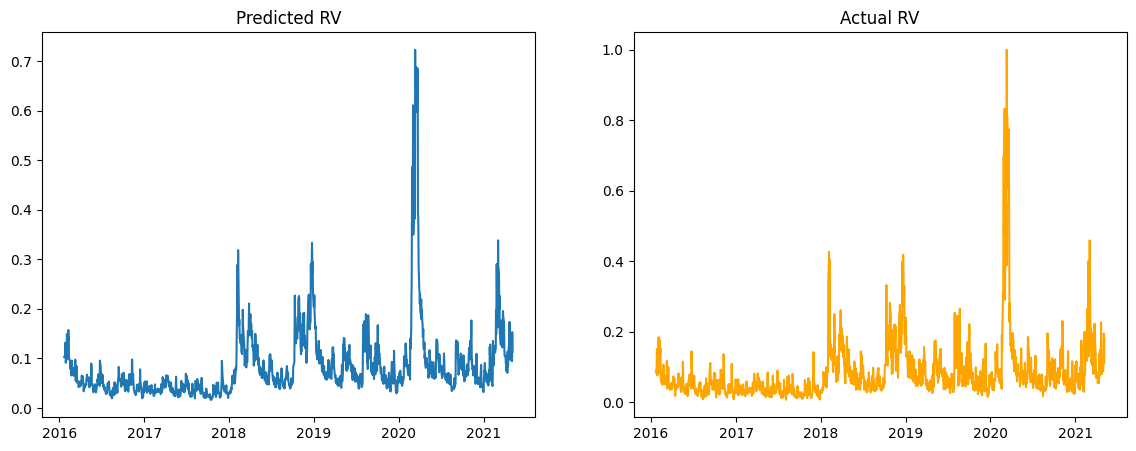

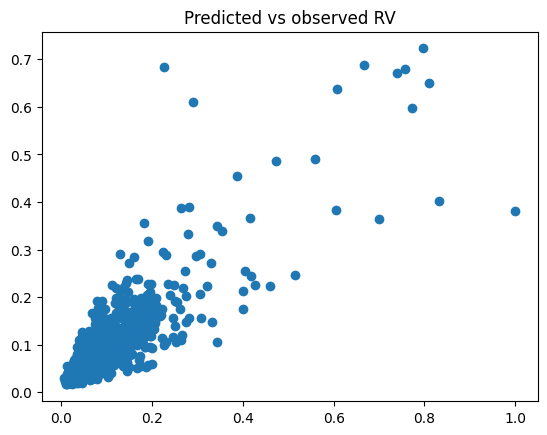

In [307]:
# Perform out of sample prediction
y_hat = results.predict(X_test)

plt.figure(figsize = (14,5))

#Predicted RV
plt.subplot(1,2,1)
plt.plot(y_test.index, y_hat)
plt.title("Predicted RV")

#Actual RV
plt.subplot(1,2,2)
plt.plot(y_test.index, y_test, color = "orange")
plt.title("Actual RV")
plt.show()

plt.scatter(y_test, y_hat)
plt.title("Predicted vs observed RV")
plt.show()

In [308]:
# Metrics
def score(y_hat, y, metric):
    """Return metrics of y_hat vs. y

    Args:
        y_hat (np.array): Predicted values
        y (np.array): Actual values
        metric (str): Metric to use

    Returns:
        float: The metric
    """
    if metric == "MSE": 
        return np.mean( (y_hat-y)**2)
    elif metric == "R_squared":
        ss_res = np.sum( (y - y_hat)**2 )
        ss_tot = np.sum( (y - np.average(y)) **2)
        return 1 - ss_res/ss_tot
    elif metric == "MAE":
        return np.mean( np.abs(y-y_hat))

In [309]:
#In-sample scores
print("In-sample scores")

y_hat_is = results.predict(X_train)
mse_is = score(y_hat_is, y_train.values.ravel(), "MSE")
r_sq_is = score(y_hat_is, y_train.values.ravel(), "R_squared")
mae_is = score(y_hat_is, y_train.values.ravel(), "MAE")

print(f"MSE:{mse_is}, R^2:{r_sq_is}, MAE:{mae_is}")      

print("----------------")
               
#Out-of-sample scores
print("Out-of-sample scores")
               
mse_oos = score(y_hat, y_test.values.ravel(), "MSE")
r_sq_oos = score(y_hat, y_test.values.ravel(), "R_squared")
mae_oos = score(y_hat, y_test.values.ravel(), "MAE")

print(f"MSE:{mse_oos}, R^2:{r_sq_oos}, MAE:{mae_oos}")

In-sample scores
MSE:0.0005915577439134929, R^2:0.6358108961635967, MAE:0.014446689775697843
----------------
Out-of-sample scores
MSE:0.002259967327270199, R^2:0.7164231279687603, MAE:0.026676022476969992


The explanatory variables explain $59.6\%$ of the variance of the dependent variable out-of-sample.

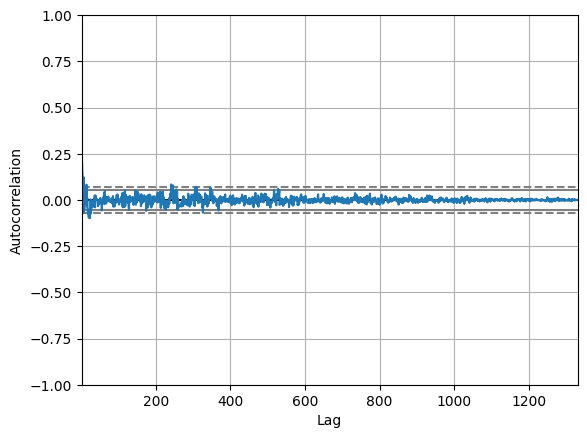

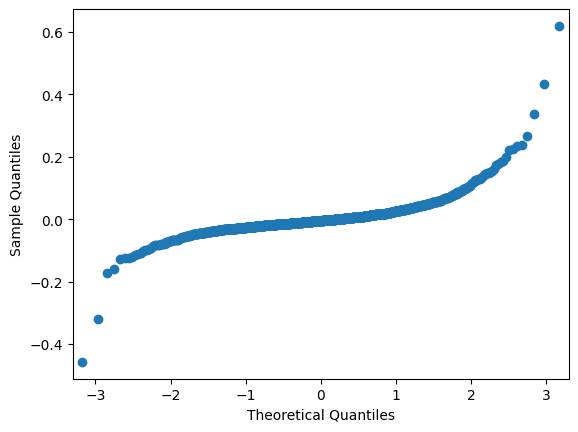

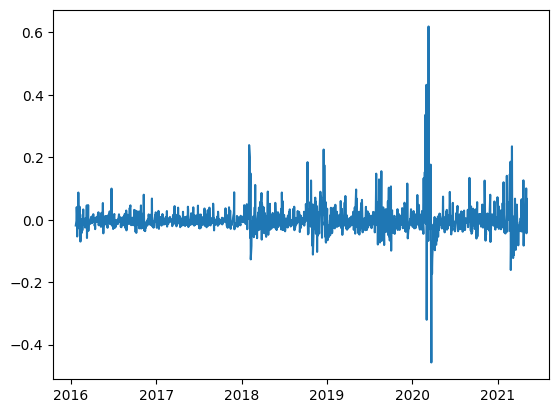

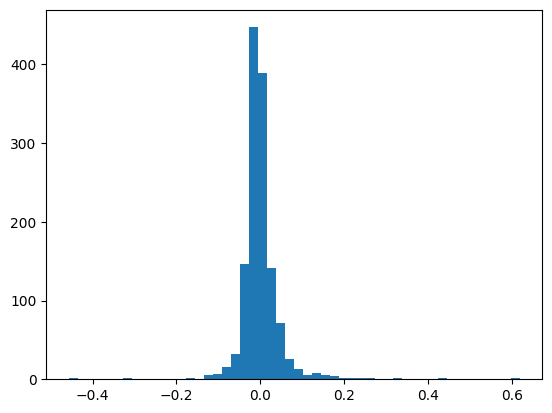

In [310]:
# Residuals
residuals = y_test.values.ravel() - y_hat

autocorrelation_plot(residuals);plt.show()
qqplot(residuals);plt.show()
plt.plot(residuals);plt.show()
plt.hist(residuals, bins = 50); plt.show()

The residuals appear to look like white noise.